# IMAGE INPAINTING
Pierre Marrec and Paul Krieger, CGDI, ENS de Lyon, 29.03.2021

In this notebook we implement an image inpainting algorithm which relys on CNNs.

In [1]:
#imports
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from os import listdir
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import random

First we get the data set. In this implementation we consider images with the shape 32*32

In [2]:
#path to our images
path_training_org= os.getcwd()+'/TrainingData3232/Original'
#list all available images
photos=os.listdir(path_training_org)

In [3]:
#this method combines the path with the photo names and returns a data set with all corresponding photos
def getImages(path):
    # return array of images
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = cv2.imread(path_training_org+'/'+ image)
        loadedImages.append(img)
    return np.array(loadedImages)

In [4]:
#get the photos
data = getImages(path_training_org)
#lets have a look at the shape etc of the data set
data.shape

(3590, 32, 32, 3)

In order to train our model later, we have to create a traing data set and a test data set. We decided to split the data set in the proportion 0.8/0.2.

In [5]:
#at the moment we do not have labels. Therefore x=y=data
x_train,x_test,y_train,y_test = train_test_split(data,data,test_size=0.2)

In [6]:
#lets have a look at the shapes of our training an testing data:
print('x_train shape:', x_train.shape)
print('x_test shape:',x_test.shape)

x_train shape: (2872, 32, 32, 3)
x_test shape: (718, 32, 32, 3)


It might also be interesting how our data looks like:

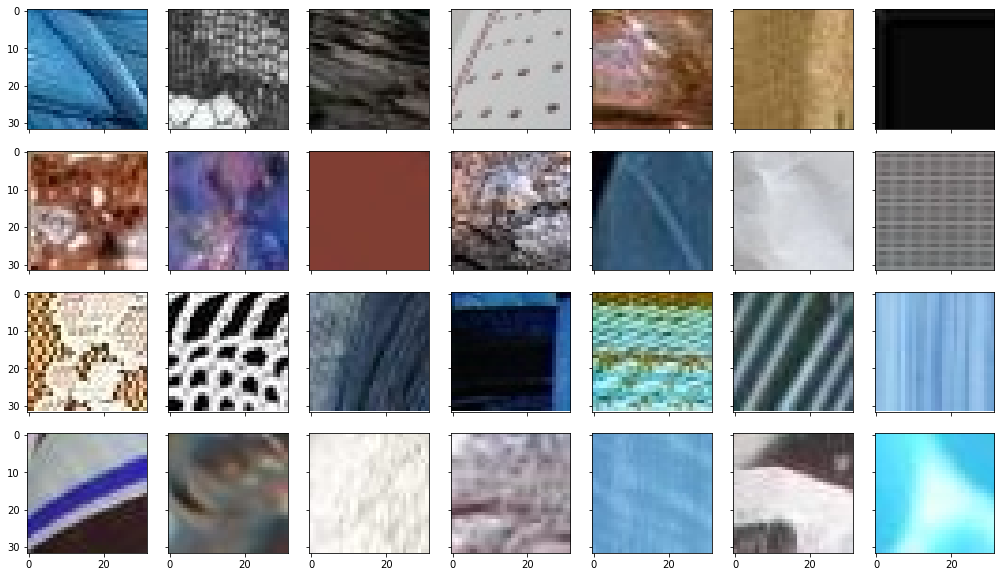

In [7]:
fig = plt.figure(figsize=(20, 10.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(4, 7),  
                 axes_pad=0.3,
                 )
for ax, image in zip(grid,x_train[:28]):
    ax.imshow(image)
plt.show()

In order to from this data set effeciently, we have to organise it as well as possible. Also, we have to remove parts of our data which we try to generate again. We also organise our data in randomly sampled batches of size 32. We introduce a new class in order to do this:

In [8]:
class createAugment(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.y = y
        self.X = X
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        
        for i, idx in enumerate(idxs):
            count = np.random.randint(1,3)

            tmp_image = self.X[idx].copy()
            
            mask = np.full(image.shape,(255,255,255),dtype=np.uint8)
            for q in range(0,count):    
                x = random.randrange(0,self.dim[0])
                y = random.randrange(0,self.dim[0])
                circle = np.random.randint(0,2)
                if circle == 0:
                    w = h = np.random.randint(1, 13, 1)[0]
                    mask[y:y+h,x:x+w] = 0
                else:
                    r = random.randrange(4,8)
                    if (self.dim[0] == 64):
                        r = random.randrange(9,15)   
                    mask = cv2.circle(mask, (x, y), r, (0,0,0), -1)
            res = cv2.bitwise_and(tmp_image, mask)

            X_batch[i,] = res/255
            y_batch[i] = self.y[idx]/255

        return X_batch, y_batch

In [9]:
#createAugment for our test and training data
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test)

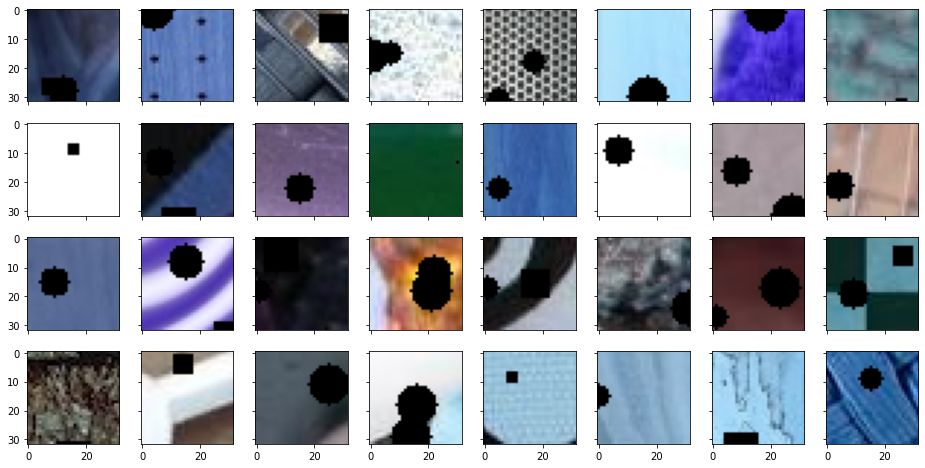

In [10]:
#we can see that we put black squares on different places of the image
sample_idx = 1 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
    ax.imshow(image)

plt.show()

In [11]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [12]:
def unet_like():
    inputs = keras.layers.Input((32, 32, 3))
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[conv10])  

In [13]:
keras.backend.clear_session()
model = unet_like()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

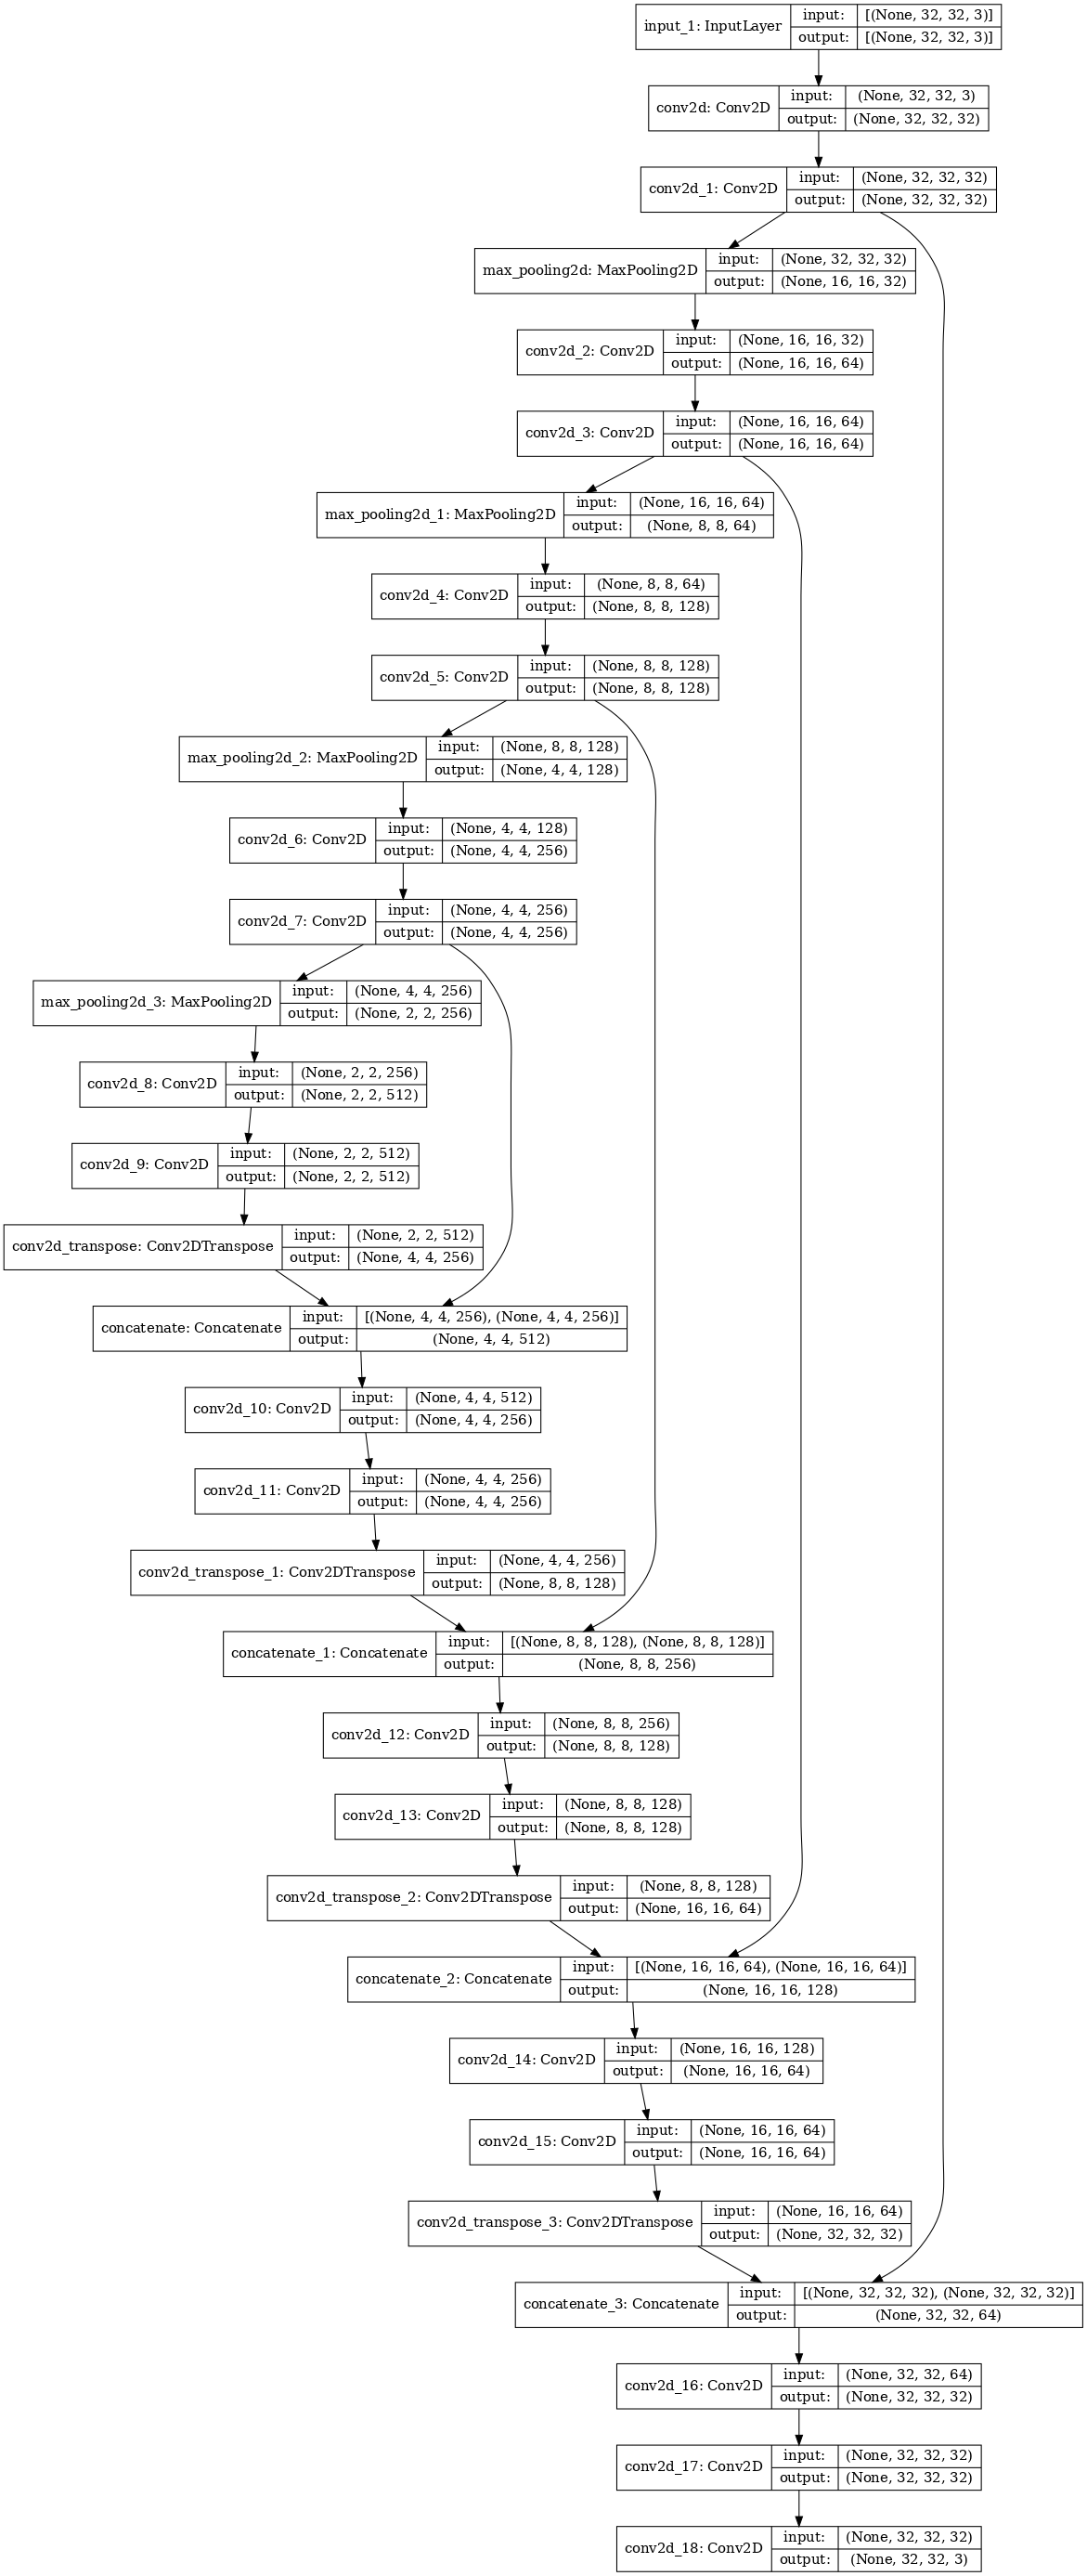

In [16]:
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [15]:
model.fit(traingen, validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=False)

Epoch 1/20
89/89 [==============================] - 42s 467ms/step - loss: 0.5330 - dice_coef: 0.6232 - val_loss: 0.5312 - val_dice_coef: 0.6294
Epoch 2/20
89/89 [==============================] - 41s 465ms/step - loss: 0.5288 - dice_coef: 0.6253 - val_loss: 0.5300 - val_dice_coef: 0.6409
Epoch 3/20
89/89 [==============================] - 42s 470ms/step - loss: 0.5256 - dice_coef: 0.6290 - val_loss: 0.5260 - val_dice_coef: 0.6294
Epoch 4/20
89/89 [==============================] - 42s 476ms/step - loss: 0.5245 - dice_coef: 0.6291 - val_loss: 0.5264 - val_dice_coef: 0.6313
Epoch 5/20
89/89 [==============================] - 41s 466ms/step - loss: 0.5233 - dice_coef: 0.6306 - val_loss: 0.5254 - val_dice_coef: 0.6341
Epoch 6/20
89/89 [==============================] - 42s 469ms/step - loss: 0.5222 - dice_coef: 0.6318 - val_loss: 0.5230 - val_dice_coef: 0.6288
Epoch 7/20
89/89 [==============================] - 42s 477ms/step - loss: 0.5218 - dice_coef: 0.6306 - val_loss: 0.5266 - val_dic

In [ ]:
## Examples
rows = 32
sample_idx = np.random.randint(0, len(testgen), rows)
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 64))
for i, idx in enumerate(sample_idx):
    sample_images, sample_labels = traingen[idx]
    img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
    impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
    axs[i][0].imshow(sample_labels[img_idx])
    axs[i][1].imshow(sample_images[img_idx])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
    cv2.imwrite("result/32"+str(idx)+"_base.png",sample_labels[img_idx]*255)
    cv2.imwrite("result/32"+str(idx)+"_mask.png",sample_images[img_idx]*255)
    cv2.imwrite("result/32"+str(idx)+"_find.png",impainted_image.reshape(impainted_image.shape[1:])*255),
plt.show()